In this Kaggle we are trying to predict if a tweet is a disaster tweet or a non disaster tweet. The training dataset has about 7k rows. As ruled by Kaggle, we will use the F1 score to assess the performance of our model. We will try different basic model and selects the one with the best results.

In [140]:
#!pip install matplotlib #you can also add the package to your virtual env
#!pip install seaborn #you can also add the package to your virtual env
#!pip install wordcloud #you can also add the package to your virtual env
#!pip install lightgbm #you can also add the package to your virtual env
#!pip install nltk #you can also add the package to your virtual env

## 0. Introduction

In [141]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM
from keras.models import Model
from keras import metrics
from tensorflow.keras.utils import to_categorical

In [142]:
import sys
print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:49:57) 
[Clang 16.0.6 ]


In [143]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [144]:
#load dataset
df = pd.read_csv('train.csv')

#display the first few rows of the dataset
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [145]:
#display length of train dataset
len(df)

7613

## 1. Exploratory Data Analysis

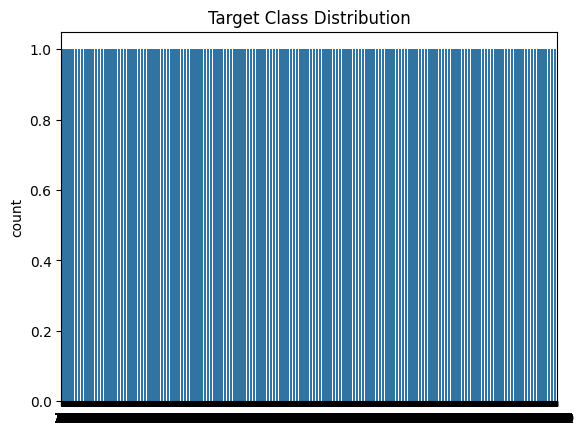

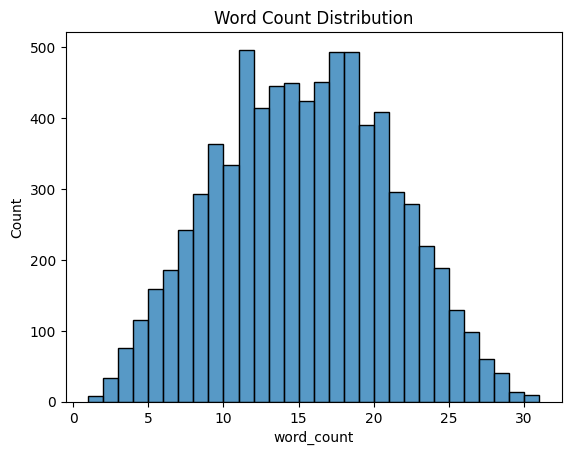

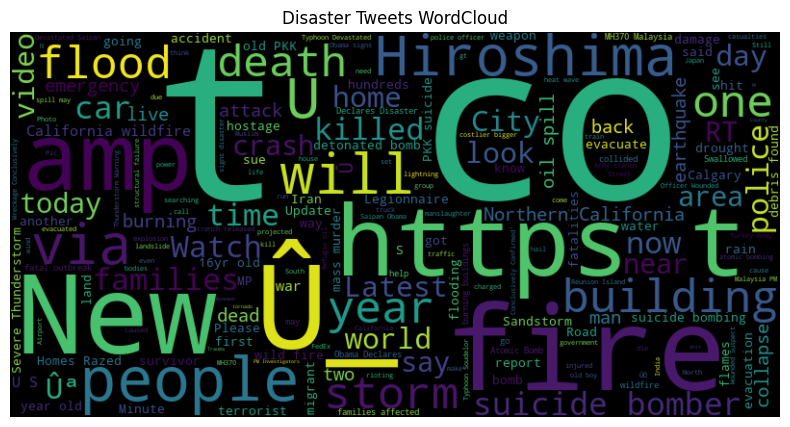

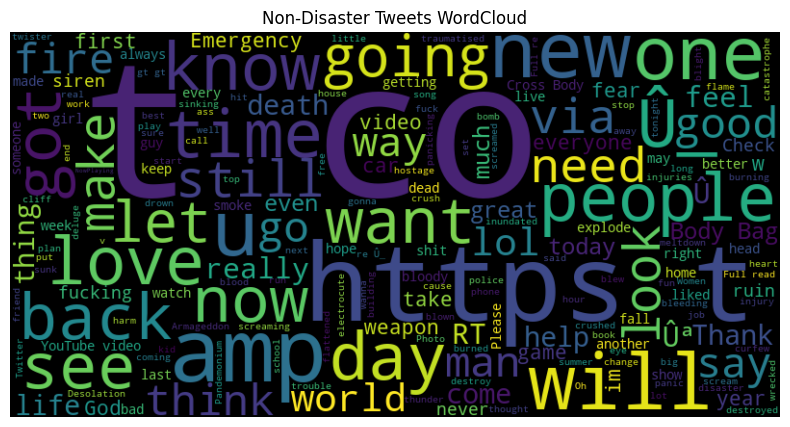

In [146]:
#check for missing values
df.isnull().sum()

#show distribution of target variable
sns.countplot(df['target'])
plt.title('Target Class Distribution')
plt.show()

#pull word count distribution
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=30)
plt.title('Word Count Distribution')
plt.show()

#generate word clouds for disaster and non-disaster tweets
disaster_tweets = ' '.join(df[df['target'] == 1]['text'])
non_disaster_tweets = ' '.join(df[df['target'] == 0]['text'])

#create WordCloud for disaster tweets
wc = WordCloud(width=800, height=400, max_words=200).generate(disaster_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Disaster Tweets WordCloud')
plt.show()

#create WordCloud for non-disaster tweets
wc = WordCloud(width=800, height=400, max_words=200).generate(non_disaster_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Disaster Tweets WordCloud')
plt.show()

## 2. Text Preprocessing

In [147]:
#download nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

#create preprocessing function
def preprocess_text(text):
    ##lowercase
    text = text.lower()
    ##remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|https\S+|@\S+|#\S+", '', text)
    ##remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    ##stem and remove stopwords
    tokens = text.split()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

#apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

#display cleaned text
df[['text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasfrancois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",13 000 peopl receiv evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi smoke pour school


## 3. Feature Engineering: TF-IDF

In [148]:
#build TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['cleaned_text']).toarray()

#define target variable
y = df['target']

## 4a. Model Selection: Logistic Regression

F1 Score: 0.7412


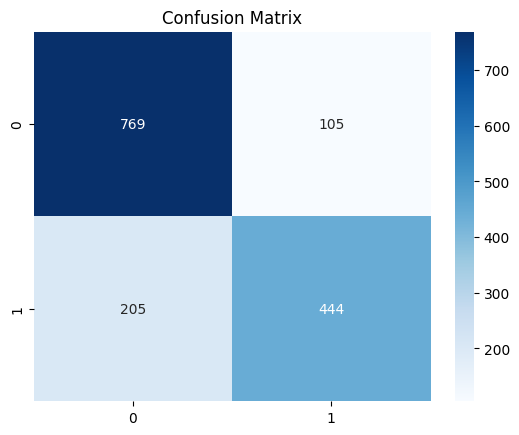

In [149]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on test set
y_pred = model.predict(X_test)

# Evaluate using F1 score
f1_sc = f1_score(y_test, y_pred)
print(f'F1 Score: {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 4b. Model Selection: Random Forest

F1 Score (Random Forest): 0.7266


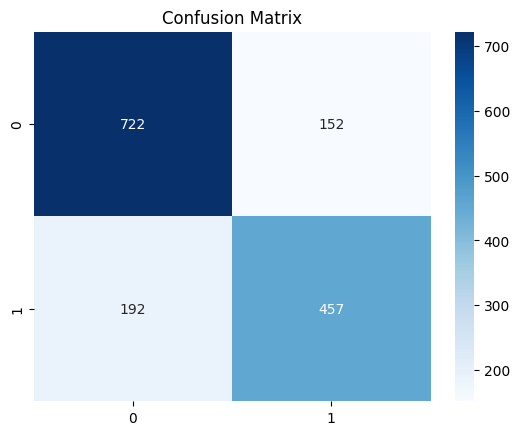

In [150]:
#initialize Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

#predicting on test set
y_pred = model.predict(X_test)

#evaluate using F1 score
f1_sc = f1_score(y_test, y_pred)
print(f'F1 Score (Random Forest): {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 4c. Model Selection: LGBM

[LightGBM] [Info] Number of positive: 2622, number of negative: 3468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9236
[LightGBM] [Info] Number of data points in the train set: 6090, number of used features: 657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430542 -> initscore=-0.279641
[LightGBM] [Info] Start training from score -0.279641
F1 Score (LGBM): 0.7280


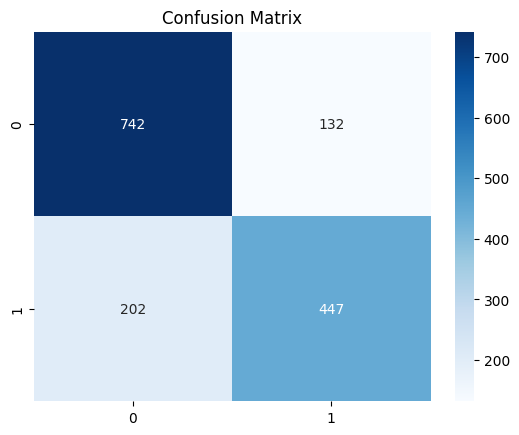

In [151]:
#initialize LGBM model
model = LGBMClassifier()
model.fit(X_train, y_train)

#predicting on test set
y_pred = model.predict(X_test)

#evaluate using F1 score
f1_sc = f1_score(y_test, y_pred)
print(f'F1 Score (LGBM): {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Without entering into the details of hyperparameters, it seems like the logistic regression shows the best performances in terms of f1 score when we use TF-IDF to tokenize the data. Let's now try to use a character level tokenizer and see if we improve models'performances.

## 5. Feature Engineering: Character Level Tokenizer

In [152]:
tk = Tokenizer(lower=True, char_level=True, oov_token='UNK')
tk.fit_on_texts(df['cleaned_text'])
sequences = tk.texts_to_sequences(df['cleaned_text'])

X = tk.texts_to_sequences(df['cleaned_text'].values)
X = pad_sequences(X,maxlen=100)

## 6. Model Selection: Logistic Regression

F1 Score: 0.4432


/Users/thomasfrancois/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


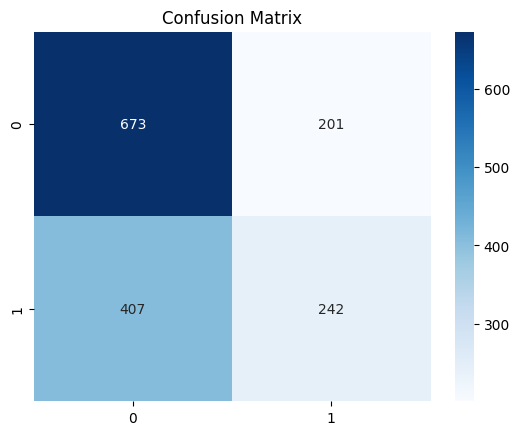

In [153]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting on test set
y_pred = model.predict(X_test)

# Evaluate using F1 score
f1_sc = f1_score(y_test, y_pred)
print(f'F1 Score: {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## 7. DL Approach

In [154]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred
    
def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [155]:
def char_cnn_model(text, labels, num_epochs):
    
    tk = Tokenizer(lower=True, char_level=True, oov_token='UNK')
    tk.fit_on_texts(text)
    sequences = tk.texts_to_sequences(text)
    
    data = pad_sequences(sequences, maxlen=input_size)
    labels = to_categorical(labels)
    
    vocab_size = len(tk.word_index)
    
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

    #creating embedding matrix
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char, i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i - 1] = 1
        embedding_weights.append(onehot)

    embedding_weights = np.array(embedding_weights)

    embedding_layer = Embedding(vocab_size + 1, vocab_size, input_length=input_size, weights=[embedding_weights])

    #Model architecture
    inputs = Input(shape=(input_size,), name='input', dtype='int64')
    x = embedding_layer(inputs)
    
    for filter_num, filter_size, pooling_size in conv_layers:
        x = Conv1D(filter_num, filter_size)(x)
        x = Dropout(dropout_p)(x)
        x = Activation('relu')(x)
        if pooling_size != -1:
            x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Flatten()(x)

    for dense_size in fully_connected_layers:
        x = Dense(dense_size, activation='relu')(x)
        x = Dropout(dropout_p)(x)
    
    predictions = Dense(num_of_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer, loss=loss_type, metrics=[precision,recall,f1])
    hist=model.fit(x_train, y_train, epochs=num_epochs,validation_data=(x_test,y_test), batch_size=100)
    
    #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return x_train, x_test, y_train, y_test,hist,model

In [156]:
def char_lstm_model(text, labels, num_epochs):
    
    tk = Tokenizer(lower=True, char_level=True, oov_token='UNK')
    tk.fit_on_texts(text)
    sequences = tk.texts_to_sequences(text)
    
    data = pad_sequences(sequences, maxlen=input_size)
    labels = to_categorical(labels)
    
    vocab_size = len(tk.word_index)
    
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

    #creating embedding matrix
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char, i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i - 1] = 1
        embedding_weights.append(onehot)

    embedding_weights = np.array(embedding_weights)

    embedding_layer = Embedding(vocab_size + 1, vocab_size, input_length=input_size, weights=[embedding_weights])

    #Model architecture
    inputs = Input(shape=(input_size,), name='input', dtype='int64')
    x = embedding_layer(inputs)
    
    for filter_num in lstm_layers:
        x = LSTM(filter_num)(x)
        x = Dropout(dropout_p)(x)
        x = Activation('relu')(x)
    x = Flatten()(x)

    for dense_size in fully_connected_layers:
        x = Dense(dense_size, activation='relu')(x)
        x = Dropout(dropout_p)(x)
    
    predictions = Dense(num_of_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=optimizer, loss=loss_type, metrics=[precision,recall,f1])
    hist=model.fit(x_train, y_train, epochs=num_epochs,validation_data=(x_test,y_test), batch_size=100)
    
    #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return x_train, x_test, y_train, y_test,hist,model


In [157]:
input_size = 100
conv_layers = [[256, 3, 3]]
lstm_layers = [128]

fully_connected_layers = [128]
num_of_classes = 2
dropout_p = 0.5
optimizer = 'adam'
loss_type = 'categorical_crossentropy'

In [158]:
x_train, x_test, y_train, y_test,hist,CNN_model = char_cnn_model(df['cleaned_text'], y, num_epochs=25)
y_pred=CNN_model.predict(x_test)
classification_rep = classification_report(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))

Epoch 1/25


2024-10-16 09:58:58.103120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.6676 - precision: 0.5373 - recall: 0.3683 - f1: 0.4213

2024-10-16 09:59:00.936565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 3s 40ms/step - loss: 0.6676 - precision: 0.5373 - recall: 0.3683 - f1: 0.4213 - val_loss: 0.6464 - val_precision: 0.6941 - val_recall: 0.3969 - val_f1: 0.5021
Epoch 2/25
69/69 [==============================] - 2s 31ms/step - loss: 0.6072 - precision: 0.6600 - recall: 0.5072 - f1: 0.5547 - val_loss: 0.6176 - val_precision: 0.6698 - val_recall: 0.4766 - val_f1: 0.5548
Epoch 3/25
69/69 [==============================] - 2s 30ms/step - loss: 0.5671 - precision: 0.7095 - recall: 0.5785 - f1: 0.6263 - val_loss: 0.6110 - val_precision: 0.6984 - val_recall: 0.4437 - val_f1: 0.5413
Epoch 4/25
69/69 [==============================] - 2s 30ms/step - loss: 0.5295 - precision: 0.7480 - recall: 0.6097 - f1: 0.6638 - val_loss: 0.6086 - val_precision: 0.6418 - val_recall: 0.5798 - val_f1: 0.6087
Epoch 5/25
69/69 [==============================] - 2s 26ms/step - loss: 0.4872 - precision: 0.7878 - recall: 0.6549 - f1: 0.7054 - val_loss: 0.6137 - val_precision: 0

2024-10-16 09:59:40.990510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


F1 Score: 0.6213


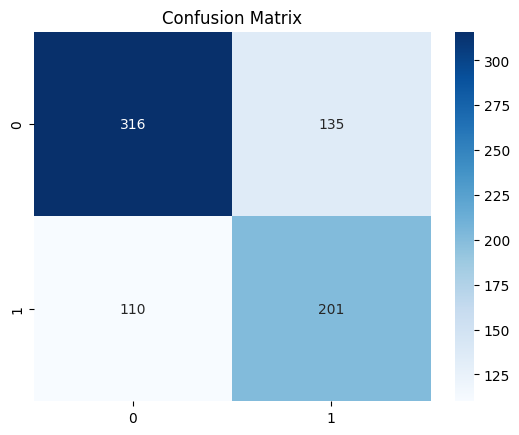

In [159]:
#evaluate using F1 score
f1_sc = f1_score(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
print(f'F1 Score: {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [160]:
classification_rep = classification_report(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
print(classification_rep)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       451
           1       0.60      0.65      0.62       311

    accuracy                           0.68       762
   macro avg       0.67      0.67      0.67       762
weighted avg       0.68      0.68      0.68       762



In [161]:
x_train, x_test, y_train, y_test,hist,LSTM_model = char_lstm_model(df['cleaned_text'], y, num_epochs=25)
y_pred=LSTM_model.predict(x_test)

Epoch 1/25


2024-10-16 09:59:41.798498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-16 09:59:41.910105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-16 09:59:42.515241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.6780 - precision: 0.2739 - recall: 0.0866 - f1: 0.1080

2024-10-16 09:59:50.887259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-16 09:59:50.941163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 11s 107ms/step - loss: 0.6780 - precision: 0.2739 - recall: 0.0866 - f1: 0.1080 - val_loss: 0.6576 - val_precision: 0.8406 - val_recall: 0.0937 - val_f1: 0.1643
Epoch 2/25
69/69 [==============================] - 3s 49ms/step - loss: 0.6469 - precision: 0.5896 - recall: 0.3743 - f1: 0.4165 - val_loss: 0.6262 - val_precision: 0.5968 - val_recall: 0.4835 - val_f1: 0.5311
Epoch 3/25
69/69 [==============================] - 3s 50ms/step - loss: 0.6280 - precision: 0.6385 - recall: 0.4680 - f1: 0.5236 - val_loss: 0.6334 - val_precision: 0.6235 - val_recall: 0.4647 - val_f1: 0.5297
Epoch 4/25
69/69 [==============================] - 4s 53ms/step - loss: 0.6229 - precision: 0.6340 - recall: 0.5428 - f1: 0.5732 - val_loss: 0.6229 - val_precision: 0.6675 - val_recall: 0.4179 - val_f1: 0.5090
Epoch 5/25
69/69 [==============================] - 3s 50ms/step - loss: 0.6150 - precision: 0.6536 - recall: 0.5281 - f1: 0.5736 - val_loss: 0.6326 - val_precision:

2024-10-16 10:01:17.764598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-10-16 10:01:17.805483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 1s 34ms/step


In [162]:
classification_rep = classification_report(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
print(classification_rep)

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       477
           1       0.60      0.71      0.65       285

    accuracy                           0.72       762
   macro avg       0.71      0.72      0.71       762
weighted avg       0.73      0.72      0.72       762



F1 Score: 0.6421


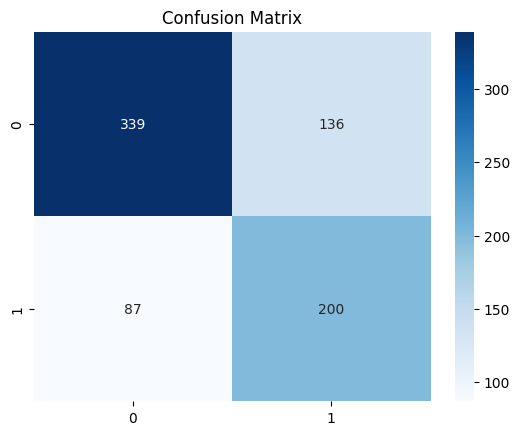

In [163]:
#evaluate using F1 score
f1_sc = f1_score(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
print(f'F1 Score: {f1_sc:.4f}')

#show confusion matrix
cm = confusion_matrix(np.argmax(y_pred,axis=-1),np.argmax(y_test,axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()